In [ ]:
import torch
import torchvision.transforms.v2 as transforms
from torchvision.utils import make_grid
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

from src.model import load_model_from_checkpoint
from datasets import load_dataset

In [ ]:
checkpoint_path = "../expiriments/afhq/checkpoint-epoch50.pth"
dataset = load_dataset("huggan/AFHQv2", streaming=True, split='train')

In [19]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
model = load_model_from_checkpoint(checkpoint_path=checkpoint_path, device='cpu')

/Users/azrail/Library/Caches/pypoetry/virtualenvs/stargan-v2-OP3wiB1a-py3.13/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
model

StarGAN(
  (generator): Generator(
    (in_block): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (out_block): Sequential(
      (0): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    )
    (downsample_block): ModuleList(
      (0): ResidualBlock(
        (interpolation): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (activation): LeakyReLU(negative_slope=0.2)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (addition): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1

In [78]:
class_zero = dataset.filter(lambda example: example["label"] == 0)
class_one = dataset.filter(lambda example: example["label"] == 1)
class_two = dataset.filter(lambda example: example["label"] == 2)
example_zero = next(iter(class_zero))
example_one = next(iter(class_one))
example_two = next(iter(class_two))

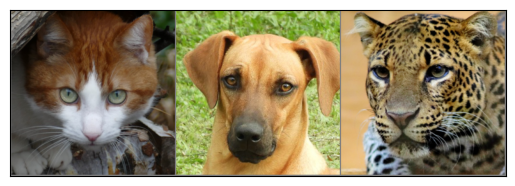

In [79]:
def denormalize(img):
    img = (img + 1) / 2
    img = (img * 255).clamp(0, 255).to(torch.uint8)
    return img


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = denormalize(img)
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

grid = make_grid([transform(example_zero['image']), transform(example_one['image']), transform(example_two['image'])])
show(grid)

### From normal latent code

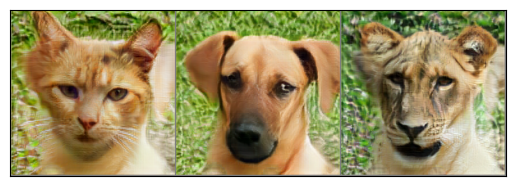

In [86]:
latent_code = torch.randn((3, 16))
target_class = torch.tensor([0, 1, 2]).long()
style_embedding = model.mapping_network(latent_code, target_class)
out = model.generator(transform(example_one['image']), style_embedding)
grid = make_grid(out)
show(grid)

### From reference image

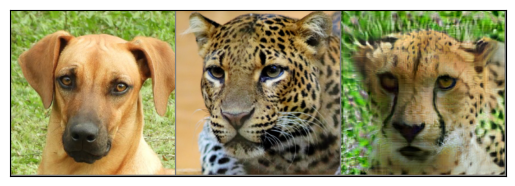

In [118]:
latent_code = torch.randn((3, 16))
reference_img = transform(example_two['image'])
target_class = torch.tensor((example_two['label'],)).long()
style_embedding = model.style_encoder(reference_img, target_class)
out = model.generator(transform(example_one['image']), style_embedding).squeeze(0)
grid = make_grid([transform(example_one['image']),transform(example_two['image']), out])
show(grid)

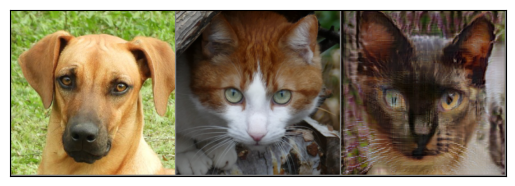

In [ ]:
latent_code = torch.randn((3, 16))
reference_img = transform(example_zero['image'])
target_class = torch.tensor((example_zero['label'],)).long()
style_embedding = model.style_encoder(reference_img, target_class)
out = model.generator(transform(example_one['image']), style_embedding).squeeze(0)
grid = make_grid([transform(example_one['image']), transform(example_zero['image']), out])
show(grid)

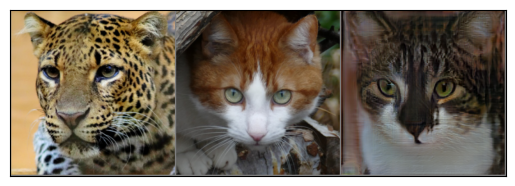

In [119]:
latent_code = torch.randn((3, 16))
reference_img = transform(example_zero['image'])
target_class = torch.tensor((example_zero['label'],)).long()
style_embedding = model.style_encoder(reference_img, target_class)
out = model.generator(transform(example_two['image']), style_embedding).squeeze(0)
grid = make_grid([transform(example_two['image']), transform(example_zero['image']), out])
show(grid)